#### This notebook generates a set of features (financial indicators) that might be used as input data for the Reinforcement Learning model 

In [82]:
import pandas as pd
import numpy as np

import ffn.core as ffn   # provides probabilistic momentum operator: ffn.calc_prob_mom(.)
import bt

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# plots of BT only work with this following command
%matplotlib inline

In [83]:
INPUT, OUTPUT = 'raw_weekly_prices', 'weekly_feature_set'

In [84]:
df = pd.read_csv(INPUT+'.csv', parse_dates=True, index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1031 entries, 2002-01-04 to 2021-10-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLK     1031 non-null   float64
 1   SPY     1031 non-null   float64
 2   TLT.O   1002 non-null   float64
 3   TAIL.K  235 non-null    float64
 4   VIX     1031 non-null   float64
dtypes: float64(5)
memory usage: 48.3 KB


---

#### Some useful functions for Feature Engineering

In [85]:
"""
Probabilistic momentum between returns series of two assets (ex. market x bonds) 
Probabilistic momentum can be defined as the probability or confidence that one asset (left) is going to outperform the other (right)
Params: 
    p_returns: dataframe of returns (pandas DataFrame)
    left_ticker: the name of the <TARGET> column at which the momentum is calculated
    right_ticker: the name of the <TARGET> column  at which the momentum is calculated
    lookback period: number of days (regular days, not business days)
    p_currentDate: reference date at which the momentum is calculated (pd.Datetime) 
    
Returns:
     mom: probabilistic momentum between left_ticker and right_ticker (ex. market x bonds) 
"""
def checkForProbMomentum(p_returns:pd.DataFrame, left_ticker: str, right_ticker: str, 
                         p_currentDate=pd.Timestamp, p_lookbackPeriod=66):
    
    v_startDate = p_currentDate - pd.DateOffset(days=p_lookbackPeriod)
    v_returns = p_returns.loc[ v_startDate:p_currentDate, [left_ticker,right_ticker] ]
        
    v_leftReturns = v_returns.iloc[:,0]
    v_rightReturns = v_returns.iloc[:,1]
        
    mom = ffn.calc_prob_mom(v_leftReturns, v_rightReturns)
     
    return mom    

"""
Rate of Change (ROC) with respect to Small and Large time windows  
Params: 
    data: pandas DataFrame
    windowSmallSize: size of "SMALL" time window
    windowLargeSize: size of "LARGE" time window
    t_col: the name of the <TARGET> column at which the rate of change is calculated
    
Returns:
     pSmall: rate of change with respect to the "SMALL" time window
     pLarge: rate of change with respect to the "LARGE" time window
     pInd: sum of pSmall and pLarge (aggregated rate of change)
"""

def rate_of_change(data:pd.DataFrame = None, t_col = '<CLOSE>', windowSmallSize:int = 13, windowLargeSize:int = 52):
    v_data = data[t_col].values
    dim = len(v_data)
    pSmall = np.full(dim,np.nan)
    pLarge = np.full(dim,np.nan)
    pInd = np.full(dim,np.nan)
    last_nan_index = sum(np.isnan(v_data))
    for t in range(last_nan_index,dim):
        vtemp = v_data[last_nan_index:t+1]
        windowSmall = vtemp[-windowSmallSize:]
        lowest = min(windowSmall)
        pSmall[t] = (vtemp[-1]/lowest - 1) * 100
        windowLarge = vtemp[-windowLargeSize:]
        largest = max(windowLarge)
        pLarge[t] = (vtemp[-1]/largest - 1) * 100
    
    pInd =  pSmall + pLarge
    
    return pInd, pSmall, pLarge

""" Slope (derivative) - similar to "momentum indicator" 
Params: 
    data: pandas DataFrame
    t_col: DataFrame column at which the first derivative is calculated   
    lag = lag for the difference operator
Returns:
     diff: pandas series
"""
def slope(data:pd.DataFrame = None, t_col = '<CLOSE>', lag:int = 3):
    diff =  data[t_col].diff(lag)
    return diff


In [86]:
# calculate probabilistic momentum between returns series of two assets (ex. market x bonds)
# probabilistic momentum definition:  “probability or confidence that one asset (left) is going to outperform the other (right)”.
# lookback period: n days (not business days)
# p_currentDate = reference date - usually the current date 
def checkForProbMomentum(p_returns:pd.DataFrame, left_ticker: str, right_ticker: str, 
                         p_currentDate=pd.Timestamp, p_lookbackPeriod=66):
    
    v_startDate = p_currentDate - pd.DateOffset(days=p_lookbackPeriod)
    v_returns = p_returns.loc[ v_startDate:p_currentDate, [left_ticker,right_ticker] ]
        
    v_leftReturns = v_returns.iloc[:,0]
    v_rightReturns = v_returns.iloc[:,1]
        
    mom = ffn.calc_prob_mom(v_leftReturns, v_rightReturns)
     
    return mom     

In [87]:
# dataframe that will hold the features
df_features = pd.DataFrame(index = df.index)
tickers_list = list(df.columns.values)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1031 entries, 2002-01-04 to 2021-10-01
Empty DataFrame

In [88]:
# log-returns
for ticker,ticker_name in zip(df,tickers_list):
    v_logRet = np.log(df[ticker] / df[ticker].shift(1))
    df_field = ticker_name + '_logReturns'
    df_features[df_field] = v_logRet
    
df_features = df_features.drop(['VIX_logReturns'], axis=1)
#df_features.fillna(value=0, inplace=True)
df_features

XLK_logReturns  SPY_logReturns  TLT.O_logReturns  \
2002-01-04             NaN             NaN               NaN   
2002-01-11        0.003410       -0.005875               NaN   
2002-01-18       -0.036560       -0.018958               NaN   
2002-01-25       -0.039938       -0.005459               NaN   
2002-02-01       -0.003696       -0.007222               NaN   
...                    ...             ...               ...   
2021-09-03        0.010437        0.009421         -0.000523   
2021-09-10       -0.005404       -0.007042         -0.005469   
2021-09-17       -0.008672       -0.008400          0.011836   
2021-09-24       -0.015118       -0.015648         -0.001441   
2021-10-01       -0.020641       -0.008097         -0.034046   

            TAIL.K_logReturns  
2002-01-04                NaN  
2002-01-11                NaN  
2002-01-18                NaN  
2002-01-25                NaN  
2002-02-01                NaN  
...                       ...  
2021-09-03      -2.668518e-03  
2021-09-10       9.614872e-04  
2021-09-17       3.251515e-03  
2021-09-24      -2.220446e-16  
2021-10-01      -8.469322e-03  

[1031 rows x 4 columns]

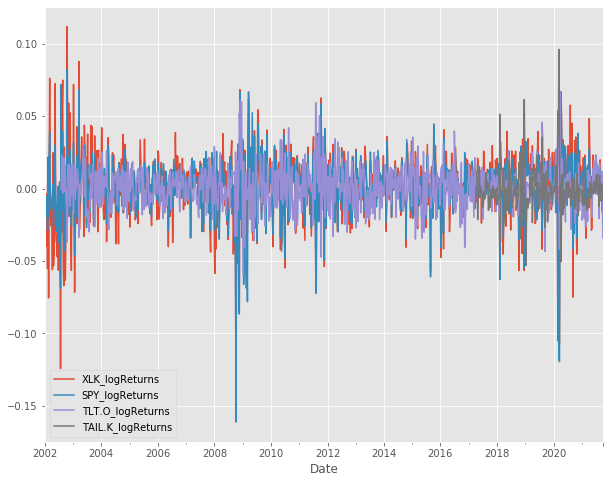

In [89]:
# ploting log-returns
df_features.iloc[:,0:4].plot(figsize=(10,8))
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [90]:
# 13-week annualized volatility
period = 13
for ticker,ticker_name in zip(df,tickers_list):
    v_logRet = np.log(df[ticker] / df[ticker].shift(1))
    v_volatility = v_logRet.rolling(window=period).std() * np.sqrt(52)
    df_field = ticker_name + '_volatility'
    df_features[df_field] = v_volatility

df_features = df_features.drop(['VIX_volatility'], axis=1)
df_features

XLK_logReturns  SPY_logReturns  TLT.O_logReturns  \
2002-01-04             NaN             NaN               NaN   
2002-01-11        0.003410       -0.005875               NaN   
2002-01-18       -0.036560       -0.018958               NaN   
2002-01-25       -0.039938       -0.005459               NaN   
2002-02-01       -0.003696       -0.007222               NaN   
...                    ...             ...               ...   
2021-09-03        0.010437        0.009421         -0.000523   
2021-09-10       -0.005404       -0.007042         -0.005469   
2021-09-17       -0.008672       -0.008400          0.011836   
2021-09-24       -0.015118       -0.015648         -0.001441   
2021-10-01       -0.020641       -0.008097         -0.034046   

            TAIL.K_logReturns  XLK_volatility  SPY_volatility  \
2002-01-04                NaN             NaN             NaN   
2002-01-11                NaN             NaN             NaN   
2002-01-18                NaN             NaN             NaN   
2002-01-25                NaN             NaN             NaN   
2002-02-01                NaN             NaN             NaN   
...                       ...             ...             ...   
2021-09-03      -2.668518e-03        0.055704        0.045420   
2021-09-10       9.614872e-04        0.063008        0.052013   
2021-09-17       3.251515e-03        0.071076        0.056657   
2021-09-24      -2.220446e-16        0.082291        0.069151   
2021-10-01      -8.469322e-03        0.087206        0.067836   

            TLT.O_volatility  TAIL.K_volatility  
2002-01-04               NaN                NaN  
2002-01-11               NaN                NaN  
2002-01-18               NaN                NaN  
2002-01-25               NaN                NaN  
2002-02-01               NaN                NaN  
...                      ...                ...  
2021-09-03          0.085886           0.048814  
2021-09-10          0.083365           0.047685  
2021-09-17          0.084613           0.048148  
2021-09-24          0.085245           0.047526  
2021-10-01          0.112953           0.050556  

[1031 rows x 8 columns]

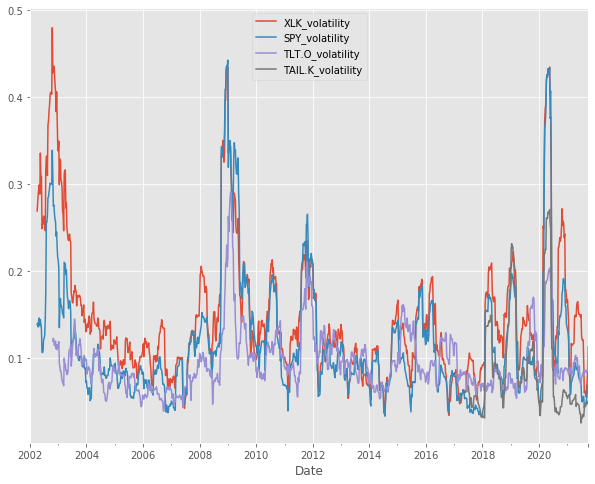

In [91]:
# ploting volatility
df_features.iloc[:,4:8].plot(figsize=(10,8))
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [92]:
# 26-week kurtosis
period = 26
for ticker,ticker_name in zip(df,tickers_list):
    v_logRet = np.log(df[ticker] / df[ticker].shift(1))
    v_kurtosis = v_logRet.rolling(window=period).kurt()
    df_field = ticker_name + '_kurtosis'
    df_features[df_field] = v_kurtosis

#df_features = df_features.drop(['VIX_kurtosis'], axis=1)
df_features

XLK_logReturns  SPY_logReturns  TLT.O_logReturns  \
2002-01-04             NaN             NaN               NaN   
2002-01-11        0.003410       -0.005875               NaN   
2002-01-18       -0.036560       -0.018958               NaN   
2002-01-25       -0.039938       -0.005459               NaN   
2002-02-01       -0.003696       -0.007222               NaN   
...                    ...             ...               ...   
2021-09-03        0.010437        0.009421         -0.000523   
2021-09-10       -0.005404       -0.007042         -0.005469   
2021-09-17       -0.008672       -0.008400          0.011836   
2021-09-24       -0.015118       -0.015648         -0.001441   
2021-10-01       -0.020641       -0.008097         -0.034046   

            TAIL.K_logReturns  XLK_volatility  SPY_volatility  \
2002-01-04                NaN             NaN             NaN   
2002-01-11                NaN             NaN             NaN   
2002-01-18                NaN             NaN             NaN   
2002-01-25                NaN             NaN             NaN   
2002-02-01                NaN             NaN             NaN   
...                       ...             ...             ...   
2021-09-03      -2.668518e-03        0.055704        0.045420   
2021-09-10       9.614872e-04        0.063008        0.052013   
2021-09-17       3.251515e-03        0.071076        0.056657   
2021-09-24      -2.220446e-16        0.082291        0.069151   
2021-10-01      -8.469322e-03        0.087206        0.067836   

            TLT.O_volatility  TAIL.K_volatility  XLK_kurtosis  SPY_kurtosis  \
2002-01-04               NaN                NaN           NaN           NaN   
2002-01-11               NaN                NaN           NaN           NaN   
2002-01-18               NaN                NaN           NaN           NaN   
2002-01-25               NaN                NaN           NaN           NaN   
2002-02-01               NaN                NaN           NaN           NaN   
...                      ...                ...           ...           ...   
2021-09-03          0.085886           0.048814      1.806307      0.412597   
2021-09-10          0.083365           0.047685      1.792885      0.264980   
2021-09-17          0.084613           0.048148      1.533264      0.113087   
2021-09-24          0.085245           0.047526      1.290947      0.230285   
2021-10-01          0.112953           0.050556      0.800086      0.201753   

            TLT.O_kurtosis  TAIL.K_kurtosis  VIX_kurtosis  
2002-01-04             NaN              NaN           NaN  
2002-01-11             NaN              NaN           NaN  
2002-01-18             NaN              NaN           NaN  
2002-01-25             NaN              NaN           NaN  
2002-02-01             NaN              NaN           NaN  
...                    ...              ...           ...  
2021-09-03       -0.160637        -0.244116      0.146906  
2021-09-10       -0.025206        -0.051295     -0.310806  
2021-09-17        0.198517         0.324874     -0.216287  
2021-09-24        0.205652         0.325834     -0.556982  
2021-10-01        1.522583         0.060539     -0.576575  

[1031 rows x 13 columns]

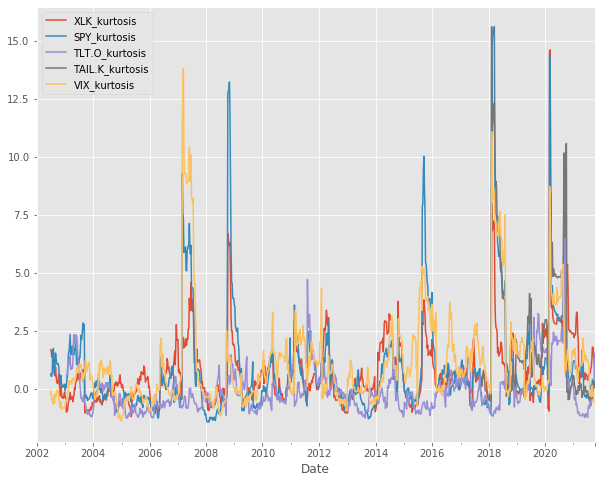

In [93]:
# ploting kurtosis
df_features.iloc[:,8:13].plot(figsize=(10,8))
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [94]:
# inserting VIX into dataframe of features
df_features['VIX'] = df['VIX']
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1031 entries, 2002-01-04 to 2021-10-01
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   XLK_logReturns     1030 non-null   float64
 1   SPY_logReturns     1030 non-null   float64
 2   TLT.O_logReturns   1001 non-null   float64
 3   TAIL.K_logReturns  234 non-null    float64
 4   XLK_volatility     1018 non-null   float64
 5   SPY_volatility     1018 non-null   float64
 6   TLT.O_volatility   989 non-null    float64
 7   TAIL.K_volatility  222 non-null    float64
 8   XLK_kurtosis       1005 non-null   float64
 9   SPY_kurtosis       1005 non-null   float64
 10  TLT.O_kurtosis     976 non-null    float64
 11  TAIL.K_kurtosis    209 non-null    float64
 12  VIX_kurtosis       1005 non-null   float64
 13  VIX                1031 non-null   float64
dtypes: float64(14)
memory usage: 120.8 KB


In [95]:
# 60 days - momentum probabilistic
period = 60 

df_returns = df.pct_change(axis=0)
dateIndex= df_returns.index

# SPY x TAIL
left_ticker = 'SPY'
right_ticker = 'TAIL.K'
column_name = left_ticker + '_' + right_ticker + '_probMomentum' 
for date in dateIndex:
    mom= checkForProbMomentum(df_returns, left_ticker, right_ticker, 
                              date, period)
    df_features.loc[date, column_name] =  mom

# SPY x TLT    
left_ticker = 'SPY'
right_ticker = 'TLT.O'
column_name = left_ticker + '_' + right_ticker + '_probMomentum' 
for date in dateIndex:
    mom= checkForProbMomentum(df_returns, left_ticker, right_ticker, 
                              date, period)
    df_features.loc[date, column_name] =  mom

# SPY x XLK    
left_ticker = 'SPY'
right_ticker = 'XLK'
column_name = left_ticker + '_' + right_ticker + '_probMomentum' 
for date in dateIndex:
    mom= checkForProbMomentum(df_returns, left_ticker, right_ticker, 
                              date, period)
    df_features.loc[date, column_name] =  mom

# XLK x TAIL    
left_ticker = 'XLK'
right_ticker = 'TAIL.K'
column_name = left_ticker + '_' + right_ticker + '_probMomentum' 
for date in dateIndex:
    mom= checkForProbMomentum(df_returns, left_ticker, right_ticker, 
                              date, period)
    df_features.loc[date, column_name] =  mom

# XLK x TLT    
left_ticker = 'XLK'
right_ticker = 'TLT.O'
column_name = left_ticker + '_' + right_ticker + '_probMomentum' 
for date in dateIndex:
    mom= checkForProbMomentum(df_returns, left_ticker, right_ticker, 
                              date, period)
    df_features.loc[date, column_name] =  mom


XLK_logReturns  SPY_logReturns  TLT.O_logReturns  \
2002-01-04             NaN             NaN               NaN   
2002-01-11        0.003410       -0.005875               NaN   
2002-01-18       -0.036560       -0.018958               NaN   
2002-01-25       -0.039938       -0.005459               NaN   
2002-02-01       -0.003696       -0.007222               NaN   
...                    ...             ...               ...   
2021-09-03        0.010437        0.009421         -0.000523   
2021-09-10       -0.005404       -0.007042         -0.005469   
2021-09-17       -0.008672       -0.008400          0.011836   
2021-09-24       -0.015118       -0.015648         -0.001441   
2021-10-01       -0.020641       -0.008097         -0.034046   

            TAIL.K_logReturns  XLK_volatility  SPY_volatility  \
2002-01-04                NaN             NaN             NaN   
2002-01-11                NaN             NaN             NaN   
2002-01-18                NaN             NaN             NaN   
2002-01-25                NaN             NaN             NaN   
2002-02-01                NaN             NaN             NaN   
...                       ...             ...             ...   
2021-09-03      -2.668518e-03        0.055704        0.045420   
2021-09-10       9.614872e-04        0.063008        0.052013   
2021-09-17       3.251515e-03        0.071076        0.056657   
2021-09-24      -2.220446e-16        0.082291        0.069151   
2021-10-01      -8.469322e-03        0.087206        0.067836   

            TLT.O_volatility  TAIL.K_volatility  XLK_kurtosis  SPY_kurtosis  \
2002-01-04               NaN                NaN           NaN           NaN   
2002-01-11               NaN                NaN           NaN           NaN   
2002-01-18               NaN                NaN           NaN           NaN   
2002-01-25               NaN                NaN           NaN           NaN   
2002-02-01               NaN                NaN           NaN           NaN   
...                      ...                ...           ...           ...   
2021-09-03          0.085886           0.048814      1.806307      0.412597   
2021-09-10          0.083365           0.047685      1.792885      0.264980   
2021-09-17          0.084613           0.048148      1.533264      0.113087   
2021-09-24          0.085245           0.047526      1.290947      0.230285   
2021-10-01          0.112953           0.050556      0.800086      0.201753   

            TLT.O_kurtosis  TAIL.K_kurtosis  VIX_kurtosis        VIX  \
2002-01-04             NaN              NaN           NaN  21.500000   
2002-01-11             NaN              NaN           NaN  22.172000   
2002-01-18             NaN              NaN           NaN  22.900000   
2002-01-25             NaN              NaN           NaN  21.912500   
2002-02-01             NaN              NaN           NaN  22.184000   
...                    ...              ...           ...        ...   
2021-09-03       -0.160637        -0.244116      0.146906  16.320000   
2021-09-10       -0.025206        -0.051295     -0.310806  18.962499   
2021-09-17        0.198517         0.324874     -0.216287  19.302000   
2021-09-24        0.205652         0.325834     -0.556982  21.464000   
2021-10-01        1.522583         0.060539     -0.576575  21.927499   

            SPY_TAIL.K_probMomentum  SPY_TLT.O_probMomentum  \
2002-01-04                      NaN                     NaN   
2002-01-11                 0.500000                0.500000   
2002-01-18                 0.500000                0.500000   
2002-01-25                 0.500000                0.500000   
2002-02-01                 0.500000                0.500000   
...                             ...                     ...   
2021-09-03                 0.657009                0.543146   
2021-09-10                 0.626681                0.576260   
2021-09-17                 0.577838                0.507709   
2021-09-24        

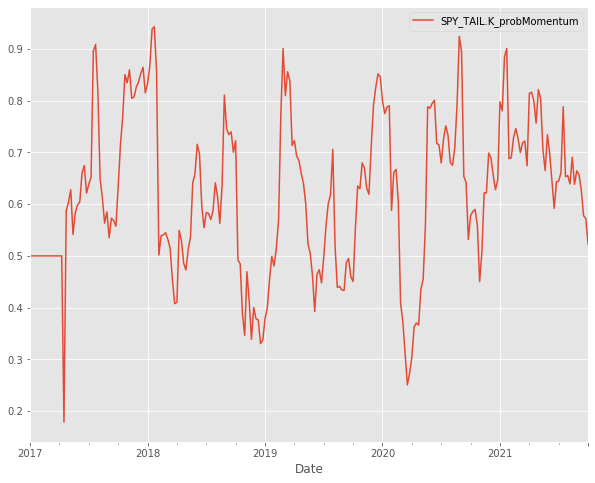

In [103]:
# ploting probabilistc momentum
v_dateFromStr = '2017-01-01'
v_dateToStr = '2021-10-01'
#df_features.loc[v_dateFromStr:v_dateToStr,['SPY_TAIL.K_probMomentum','SPY_TLT.O_probMomentum','SPY_XLK_probMomentum', 'XLK_TAIL.K_probMomentum', 
#                   'XLK_TLT.O_probMomentum']].plot(figsize=(10,8))
df_features.loc[v_dateFromStr:v_dateToStr,'SPY_TAIL.K_probMomentum'].plot(figsize=(10,8))

plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

In [104]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1031 entries, 2002-01-04 to 2021-10-01
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   XLK_logReturns           1030 non-null   float64
 1   SPY_logReturns           1030 non-null   float64
 2   TLT.O_logReturns         1001 non-null   float64
 3   TAIL.K_logReturns        234 non-null    float64
 4   XLK_volatility           1018 non-null   float64
 5   SPY_volatility           1018 non-null   float64
 6   TLT.O_volatility         989 non-null    float64
 7   TAIL.K_volatility        222 non-null    float64
 8   XLK_kurtosis             1005 non-null   float64
 9   SPY_kurtosis             1005 non-null   float64
 10  TLT.O_kurtosis           976 non-null    float64
 11  TAIL.K_kurtosis          209 non-null    float64
 12  VIX_kurtosis             1005 non-null   float64
 13  VIX                      1031 non-null   float64
 14  SPY_TA